# **Cherry Disease Classification**

### Import all the Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import keras
from keras import models, layers
import matplotlib.pyplot as plt

### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20

### Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Smart Farmer\Cherry",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2890 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Healthy(including_sour)', 'Powdery Mildew(including_sour)']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

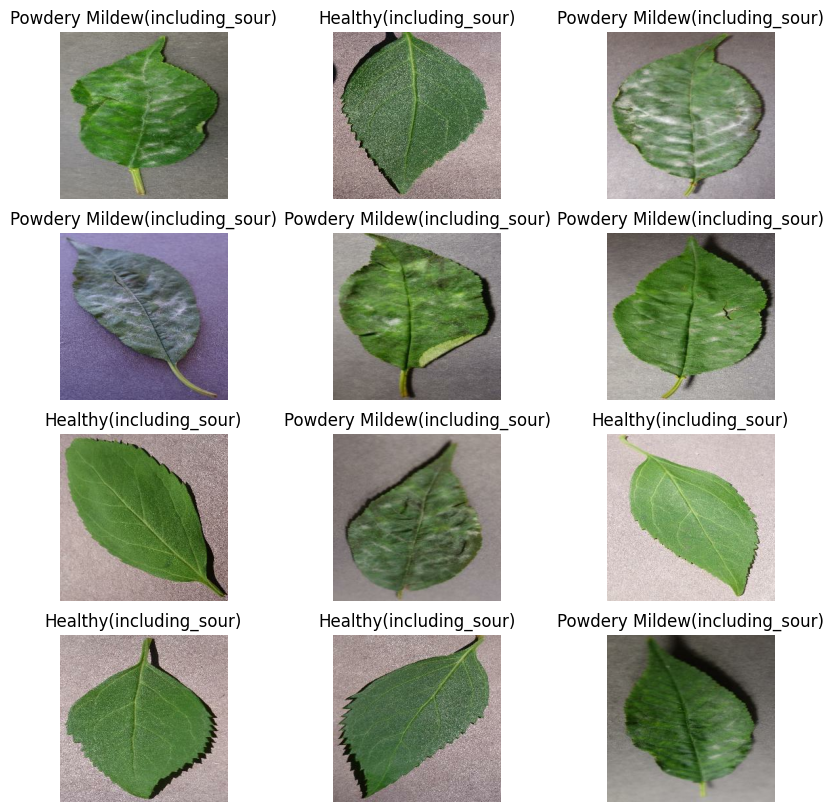

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [12]:
len(dataset)

91

In [13]:
train_size = 0.8
len(dataset)*train_size

72.8

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

37

In [16]:
val_size=0.1
len(dataset)*val_size

9.1

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

31

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

72

In [22]:
len(val_ds)

9

In [23]:
len(test_ds)

10

### Cache, Shuffle, and Prefetch the Dataset

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20


72/72 [==============================] - 122s 979ms/step - loss: 0.3931 - accuracy: 0.8050 - val_loss: 0.2011 - val_accuracy: 0.9340
Epoch 2/20
72/72 [==============================] - 114s 2s/step - loss: 0.1776 - accuracy: 0.9365 - val_loss: 0.1070 - val_accuracy: 0.9653
Epoch 3/20
72/72 [==============================] - 77s 1s/step - loss: 0.1095 - accuracy: 0.9623 - val_loss: 0.0628 - val_accuracy: 0.9861
Epoch 4/20
72/72 [==============================] - 53s 734ms/step - loss: 0.0722 - accuracy: 0.9750 - val_loss: 0.0288 - val_accuracy: 0.9896
Epoch 5/20
72/72 [==============================] - 47s 653ms/step - loss: 0.0456 - accuracy: 0.9882 - val_loss: 0.0270 - val_accuracy: 0.9896
Epoch 6/20
72/72 [==============================] - 45s 621ms/step - loss: 0.0434 - accuracy: 0.9882 - val_loss: 0.0361 - val_accuracy: 0.9861
Epoch 7/20
72/72 [==============================] - 45s 620ms/step - loss: 0.0230 - accuracy: 0.9934 - val_loss: 0.0049 - val_accuracy: 1.0000
E

In [32]:
model.save('Cherry.keras')

In [33]:
model = keras.models.load_model("D:\Smart Farmer\Cherry\Cherry.keras")

In [34]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 123s 156ms/step - loss: 0.0152 - accuracy: 0.9969


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [35]:
scores

[0.015209692530333996, 0.996874988079071]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 72}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [39]:
type(history.history['loss'])

list

In [40]:
len(history.history['loss'])

20

In [41]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.393064945936203,
 0.17760474979877472,
 0.10950056463479996,
 0.07223032414913177,
 0.0456104576587677]

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

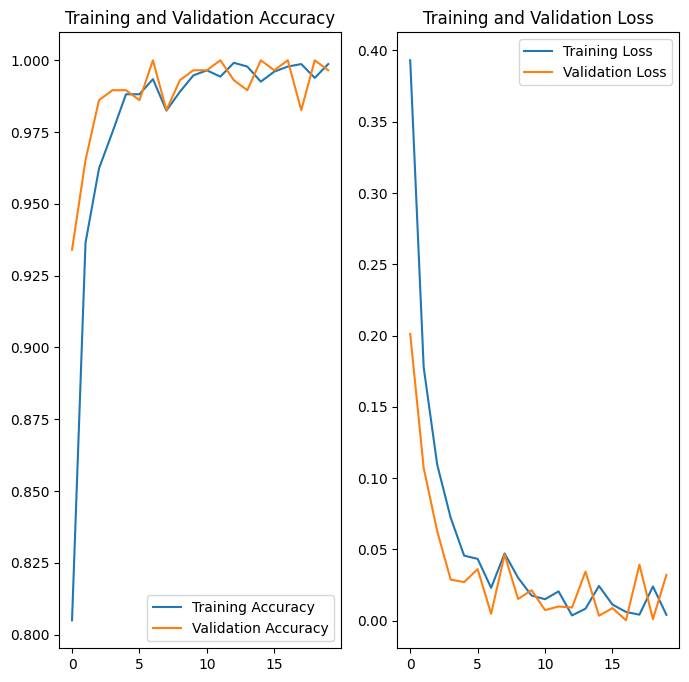

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Powdery Mildew(including_sour)
1/1 [==============================] - 4s 4s/step
predicted label: Powdery Mildew(including_sour)


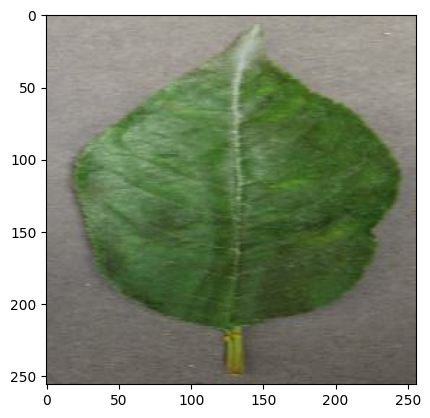

In [44]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 29ms/step


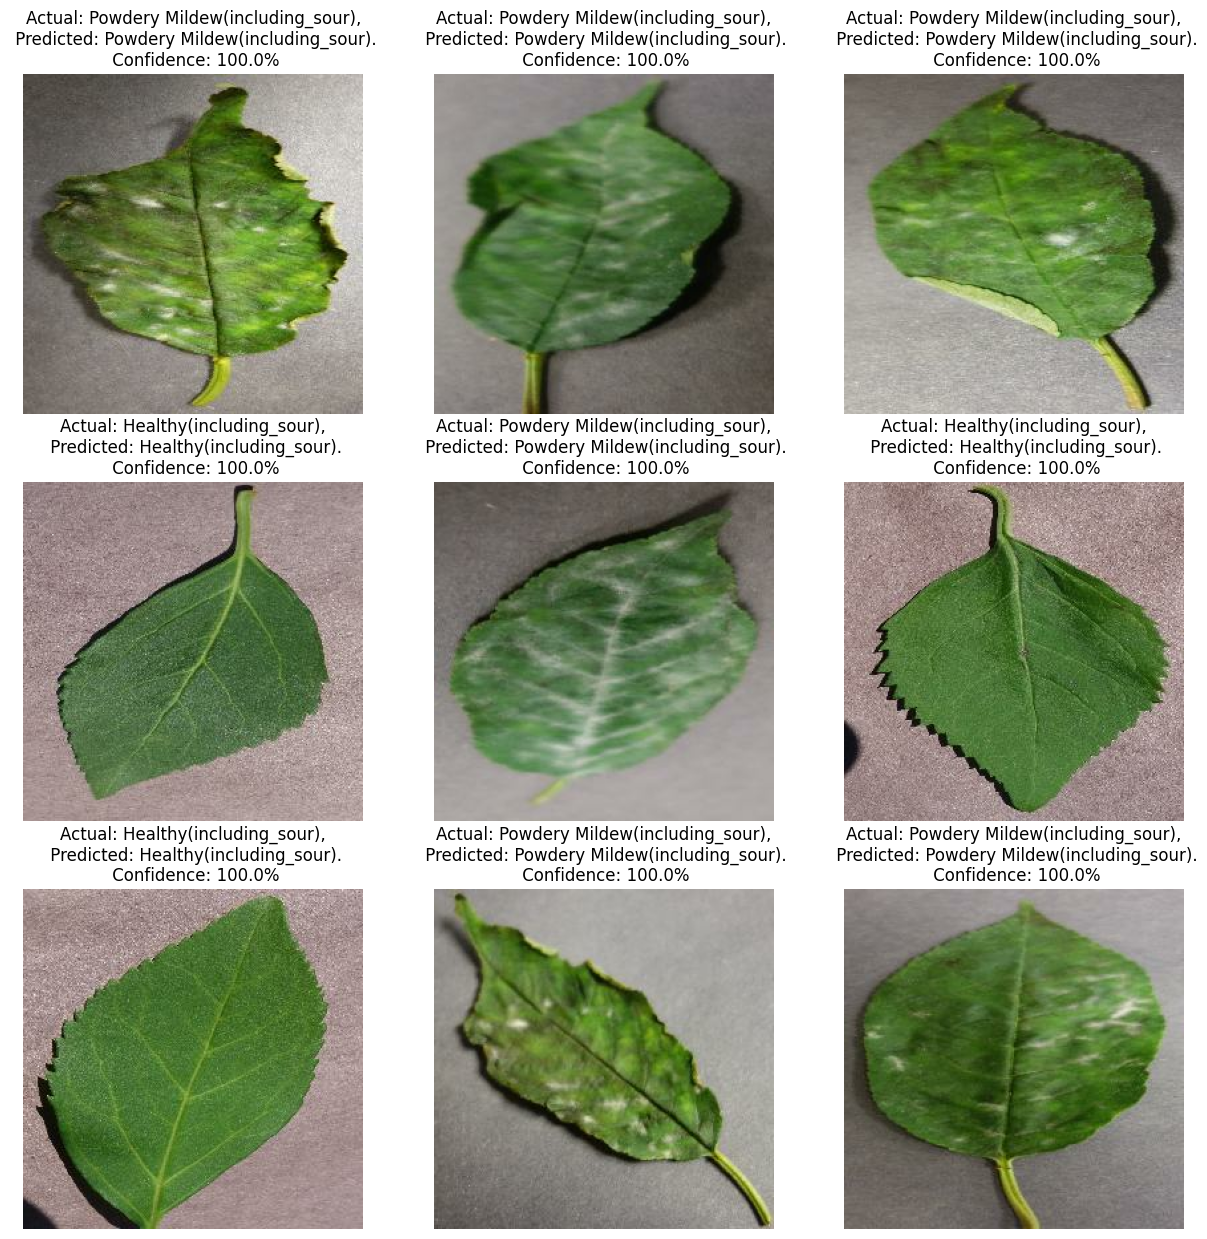

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")